In this notebook, we compute invariant sets for the planar system with univariate input of Example ?.? of [???].
We need to select an semidefinite programming solver to find the invariant set. A complete list of available solvers is [available here](https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1).

In [1]:
using MosekTools
using JuMP
solver = with_optimizer(Mosek.Optimizer, QUIET=true)

OptimizerFactory(Mosek.Optimizer, (), Base.Iterators.Pairs(:QUIET => 1))

We first define the safe sets and input sets for our system using [Polyhedra](https://github.com/JuliaPolyhedra/Polyhedra.jl).

In [2]:
using Polyhedra
G = [-0.7238   -0.5117
      0.2558   -0.8091
     -0.0528    0.7725
     -0.1060   -0.7190
     -0.1252    0.1868
      0.7232   -0.9371
      0.4235    0.6708]
F = [0.2990;
     0.0983;
     0.0276;
     0.1202;
     0.0348;
     0.0921;
     0.0240]
safe_set = polyhedron(hrep(G, F), DefaultLibrary{Float64}(solver))
cheby_center, cheby_radius = chebyshevcenter(safe_set, solver)
input_set = polyhedron(convexhull([-2], [2]))

Polyhedron Interval{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1},StaticArrays.Size{(1,)}}:
2-element iterator of HalfSpace{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1}}:
 HalfSpace([1], 2)
 HalfSpace([-1], 2):
2-element iterator of StaticArrays.SArray{Tuple{1},Int64,1,1}:
 [2]
 [-2]

We new define the dynamic of our system and create it using [MathematicalSystems](https://github.com/JuliaReach/MathematicalSystems.jl/).

In [3]:
using MathematicalSystems
A = [1 0.1
     0 1]
B = reshape([0, 0.05], 2, 1)
using SwitchOnSafety
system = ConstrainedLinearControlDiscreteSystem(A, B, safe_set, input_set)

ConstrainedLinearControlDiscreteSystem{Float64,Array{Float64,2},Array{Float64,2},DefaultPolyhedron{Float64,MixedMatHRep{Float64,Array{Float64,2}},MixedMatVRep{Float64,Array{Float64,2}}},Interval{Int64,StaticArrays.SArray{Tuple{1},Int64,1,1},StaticArrays.Size{(1,)}}}([1.0 0.1; 0.0 1.0], [0.0; 0.05], HalfSpace([-0.7238, -0.5117], 0.299) ∩ HalfSpace([0.2558, -0.8091], 0.0983) ∩ HalfSpace([-0.0528, 0.7725], 0.0276) ∩ HalfSpace([-0.106, -0.719], 0.1202) ∩ HalfSpace([-0.1252, 0.1868], 0.0348) ∩ HalfSpace([0.7232, -0.9371], 0.0921) ∩ HalfSpace([0.4235, 0.6708], 0.024), HalfSpace([1], 2) ∩ HalfSpace([-1], 2) : convexhull([2], [-2]))

We now compute the invariant set by searching for any ellipsoid with a given point in its interior.
As the system is reformulated into an algebraic system with safe set `safe_set * input_set`, the Chebyshev center is `(cheby_center, 0)` (note that `Polyhedra.chebyshevcenter(safe * input)` is currently incorrect because of https://github.com/JuliaPolyhedra/Polyhedra.jl/issues/125) where `cheby_center` is the Chebyshev center of `safe_set`.
To avoid having to solve Bilinear Matrix Inequalities, we set the S-procedure scaling to `1.05` (found by a few trials, checking what gives the best `objective_value`).

In [4]:
S_procedure_scaling = 1.05
cheby_center, cheby_radius = chebyshevcenter(safe_set, solver)
cheby = [cheby_center; 0.0]
using SwitchOnSafety
variable = Ellipsoid(point = SetProg.InteriorPoint(cheby))
max_vol_ell = invariant_set(system, solver, variable, λ = S_procedure_scaling)

MOI.get(model, MOI.SolveTime()) = 0.006247997283935547
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.028504573732809416


SetProg.Sets.Translation{SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}},Float64,Array{Float64,1}}(SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.011823676265802545 -0.005656250962580171; -0.005656250962580171 0.005237409068311501])), [-0.12627495752829762, -0.050786190168961506])

Instead of maximizing the volume, we can maximize the L1 norm.

In [5]:
using SwitchOnSafety
max_tr_ell = invariant_set(system, solver, variable, λ = S_procedure_scaling, volume_heuristic = ell -> L1_heuristic(ell, ones(3)))

MOI.get(model, MOI.SolveTime()) = 0.004029035568237305
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 2.6017941640305366


SetProg.Sets.Translation{SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}},Float64,Array{Float64,1}}(SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.006697532777042252 -0.004870215458365097; -0.004870215458365097 0.006087184494292981])), [-0.11515031330422269, -0.05450878874427739])

We can see that we get a larger ellipsoids for the volume maximization but not for the L1 norm as maximizing the L1 integral over the hypercube centered at the origin is not a very good heuristic. We should instaed maximize the L1 integral over the safe set but this is not implemented yet in [SetProg](https://github.com/blegat/SetProg.jl).

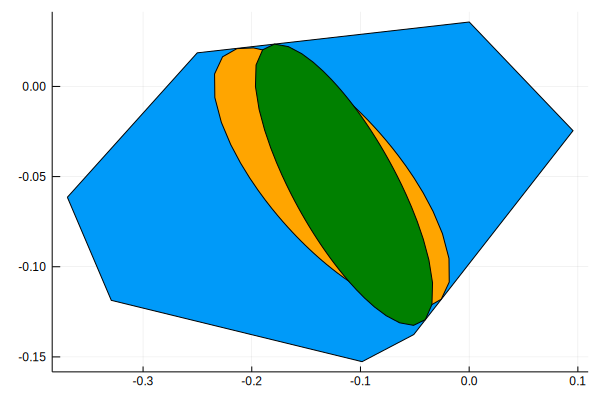

In [6]:
using Plots
plot(safe_set)
plot!(project(max_vol_ell, 1:2), color=:orange)
plot!(project(max_tr_ell, 1:2), color=:green)